In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 10]


# Preprocessing

In [ ]:
from preprocessing import *

fpath_mapping_df = clean_filepath_filename_mapping_csv(
    "Breast-Cancer-MRI-filepath_filename-mapping.csv"
)


In [5]:
sample_subject = "Breast_MRI_025"

(
    image_array,
    dcm_data,
    nrrd_breast_data,
    nrrd_dv_data,
) = read_precontrast_mri_and_segmentation(
    sample_subject, "Duke-Breast-Cancer-MRI", fpath_mapping_df, "train_annotations"
)

image_array = zscore_image(normalize_image(image_array))

# Save data

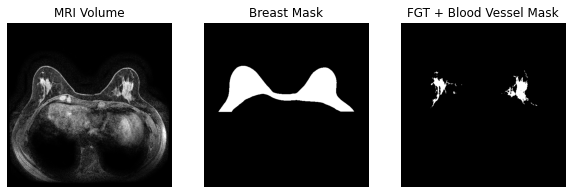

In [14]:
plt.subplot(1, 3, 1)
plt.title("MRI Volume")
plt.imshow(image_array[:, :, 50], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Breast Mask")
plt.imshow(nrrd_breast_data[:, :, 50], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("FGT + Blood Vessel Mask")
plt.imshow(nrrd_dv_data[:, :, 50], cmap="gray")
plt.axis("off")

plt.show()

## Sample Modeling

In [ ]:
# Breast Training sample script

from dataset_3d import Dataset3DRandom
from train import train_model
from unet import UNet3D
import torchio as tio

input_dim = 96
total_train_samples = 20000
total_val_samples = 4000

num_blocks = 3
model_save_name = "sample_breast_model"
n_channels = 1
n_classes = 1
batch_size = 16
epochs = 20

train_image_dir = "data/mri_data/train"
val_image_dir = "data/mri_data/val"
train_mask_dir = "data/segmentations/breast_npy/train"
val_mask_dir = "data/segmentations/breast_npy/val"

model_save_dir = "model_save_dir"

train_transforms = tio.Compose([])

val_transforms = tio.Compose([])

train_dataset = Dataset3DRandom(
    image_dir=train_image_dir,
    mask_dir=val_mask_dir,
    input_dim=input_dim,
    total_samples=total_train_samples,
    transforms=train_transforms,
    one_hot_mask=True,
)

val_dataset = Dataset3DRandom(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    input_dim=input_dim,
    total_samples=total_val_samples,
    transforms=val_transforms,
    one_hot_mask=True,
)

unet = UNet3D(
    in_channels=n_channels,
    out_classes=n_classes,
    num_encoding_blocks=num_blocks,
    padding=True,
    normalization="batch",
)

trained_unet = train_model(
    model=unet,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    n_classes=n_channels,
    n_channels=n_classes,
    batch_size=batch_size,
    learning_rate=3e-4,
    epochs=epochs,
    model_save_dir=model_save_dir,
    model_save_name=model_save_name,
    num_workers=8,
    loss="cross",
)

In [ ]:
# FGT + Blood Vessel Training sample script

from dataset_3d import Dataset3DRandom
from train import train_model
from unet import UNet3D
import torchio as tio

input_dim = 96
total_train_samples = 20000
total_val_samples = 4000

num_blocks = 3
model_save_name = "sample_breast_model"
n_channels = 1
n_classes = 3
batch_size = 16
epochs = 20

train_image_dir = "data/mri_data/train"
val_image_dir = "data/mri_data/val"

train_mask_dir = "data/segmentations/dv_npy/train"
val_mask_dir = "data/segmentations/dv_npy/val"

train_input_mask_dir = "data/preds/breast_model_preds/train"
train_val_mask_dir = "data/preds/breast_model_preds/val"

model_save_dir = "model_save_dir"

train_transforms = tio.Compose([])

val_transforms = tio.Compose([])

train_dataset = Dataset3DRandom(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    additional_input_dir=train_input_mask_dir,
    input_dim=input_dim,
    total_samples=total_train_samples,
    transforms=train_transforms,
    one_hot_mask=True,
)

val_dataset = Dataset3DRandom(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    additional_input_dir=train_val_mask_dir,
    input_dim=input_dim,
    total_samples=total_val_samples,
    transforms=val_transforms,
    one_hot_mask=True,
)

unet = UNet3D(
    in_channels=n_channels,
    out_classes=n_classes,
    num_encoding_blocks=num_blocks,
    padding=True,
    normalization="batch",
)

trained_unet = train_model(
    model=unet,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    n_classes=n_channels,
    n_channels=n_classes,
    batch_size=batch_size,
    learning_rate=3e-4,
    epochs=epochs,
    model_save_dir=model_save_dir,
    model_save_name=model_save_name,
    num_workers=8,
    loss="dice",
)